### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта 

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 5


### Дисциплина: Методы машинного обучения

##### Студент:  Матюхин Григорий Васильевич
##### Группа:   НПИбд-01-21

## Москва 2024
***

### Вариант №9
1. Набор данных beans 
2. Классы с метками 1,0,2 
3. Требования к архитектуре сети MLP: 
    - Кол-во скрытых слоев 6 
    - Кол-во нейронов 120 в первом скрытом слое, уменьшающееся на 10 с каждым последующим скрытым слоем 
    - Оптимизатор Adadelta 
    - Функция активации в скрытых слоях leaky_relu 
    - Слои dropout после каждого нечетного скрытого слоя 
4. Требования к архитектуре сети CNN: 
    - Кол-во сверточных слоев 3 
    - Количество фильтров в сверточных слоях 32 
    - Размеры фильтра 3х3 
    - Оптимизатор AdamW 
    - Функция активации в сверточных слоях relu 
    - Функция активации в скрытых плотных слоях swish 
    - Регуляризация L2 в каждом скрытом плотном слое 
5. Показатель качества бинарной классификации: 
    - индекс Фоулкса – Мэллоуса, равный корню квадратному из TP/(TP + TN) * TP/(TP + FP) 
6. Показатель качества многоклассовой классификации: 
    - максимальная точность классов, где точность (precision) класса равна доле правильных предсказаний для всех точек, относимых классификатором к этому классу. 

# Выполнение

## 1. Загружаем датасет

In [1]:
import tensorflow_datasets as tfds
import pandas as pd

In [2]:
ds_train, ds_test = tfds.load("beans", split=["train", "test"])
df_train = tfds.as_dataframe(ds_train)
df_test = tfds.as_dataframe(ds_test)
len(df_train), len(df_test)

2024-05-17 06:37:28.627546: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-17 06:37:28.794813: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-17 06:37:29.368016: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 06:37:30.793468: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-17 06:37:32.527404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-17 06:37:33.212149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

(1034, 128)

## 2. Визуализация изображений

In [3]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

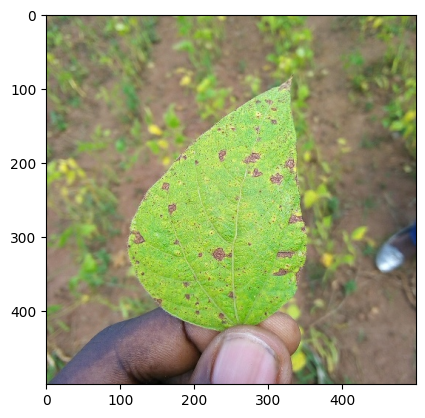

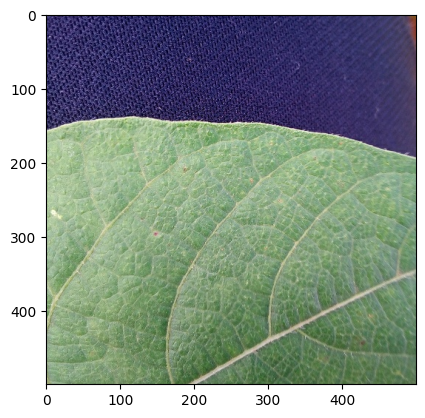

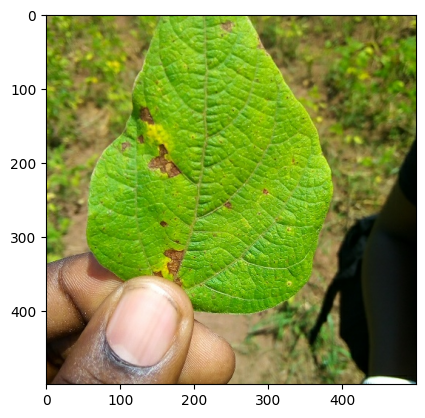

In [4]:
rng_state = 1
for i in df_train.sample(n=3, random_state=rng_state)["image"]:
    img = Image.fromarray(i)
    plt.figure()
    plt.imshow(img)

## 3. Сравнение сетей MLP и CNN

### 3.1. Выбор классов

In [5]:
import numpy as np

In [6]:
b_df_train = df_train[df_train.label.isin([0, 1])]
b_df_test = df_test[df_test.label.isin([0, 1])]

In [7]:
input_shape = b_df_train.iloc[0]["image"].shape
input_shape

(500, 500, 3)

In [8]:
b_train_labels = b_df_train['label'].to_numpy(dtype=np.float32)
b_test_labels = b_df_test['label'].to_numpy(dtype=np.float32)
b_train_labels.shape, b_test_labels.shape

((693,), (86,))

In [9]:
b_train_images = np.zeros(shape=(b_df_train.shape[0],*input_shape), dtype=np.float32)
b_test_images  = np.zeros(shape=(b_df_test.shape[0],*input_shape), dtype=np.float32)
b_train_images.shape, b_test_images.shape

((693, 500, 500, 3), (86, 500, 500, 3))

In [10]:
for idx in range(b_train_labels.shape[0]):
    b_train_images[idx,:,:,:] = \
        np.array(Image.fromarray(b_df_train.iloc[idx]['image']))

for idx in range(b_test_labels.shape[0]):
    b_test_images[idx,:,:,:] = \
        np.array(Image.fromarray(b_df_test.iloc[idx]['image']))

b_train_images.shape, b_test_images.shape

((693, 500, 500, 3), (86, 500, 500, 3))

In [11]:
b_train_images /= 255
b_test_images  /= 255

### 3.2. MLP

In [12]:
import tensorflow as tf

In [13]:
tf.random.set_seed(rng_state)
dropout_rate = 0.3

bin_mlp = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation="leaky_relu"),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(110, activation="leaky_relu"),
    tf.keras.layers.Dense(100, activation="leaky_relu"),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(90, activation="leaky_relu"),
    tf.keras.layers.Dense(80, activation="leaky_relu"),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(70, activation="leaky_relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

bin_mlp.summary()

bin_mlp.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adadelta(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

bin_mlp_hist = bin_mlp.fit(
    b_train_images,
    b_train_labels,
    epochs=50,
    batch_size=32,
    validation_data=(b_test_images, b_test_labels)
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 750000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │    90,000,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 110)            │        13,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        11,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 90)             │         9,090 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 70)             │         5,670 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,046,641 (343.50 MB)

 Trainable params: 90,046,641 (343.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2024-05-17 03:58:01.517517: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2079000000 exceeds 10% of free system memory.


22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 941ms/step - accuracy: 0.4932 - loss: 0.6993 - val_accuracy: 0.6279 - val_loss: 0.6785
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 931ms/step - accuracy: 0.5333 - loss: 0.6873 - val_accuracy: 0.5465 - val_loss: 0.6763
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 933ms/step - accuracy: 0.5387 - loss: 0.6854 - val_accuracy: 0.5930 - val_loss: 0.6821
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 933ms/step - accuracy: 0.5695 - loss: 0.6820 - val_accuracy: 0.6860 - val_loss: 0.6624
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 925ms/step - accuracy: 0.6161 - loss: 0.6640 - val_accuracy: 0.6512 - val_loss: 0.6621
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 929ms/step - accuracy: 0.5920 - loss: 0.6677 - val_accuracy: 0.6860 - val_loss: 0.6421
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 942ms/step - accuracy: 0.5995 - loss: 0.6628 - val_accuracy: 0.6744 - val_loss: 0.6288
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 932ms/step - accuracy: 0.6004 - loss: 0.6591 - val_accuracy: 0.697

### 3.3. CNN

In [14]:
tf.random.set_seed(rng_state)
dropout_rate = 0.3
l2 = 0.1

bin_cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding="same"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding="same"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=dropout_rate),
    tf.keras.layers.Dense(64, activation="swish", kernel_regularizer=tf.keras.regularizers.L2(l2=l2)),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

bin_cnn.summary()

bin_cnn.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.AdamW(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

bin_cnn_hist = bin_cnn.fit(
    b_train_images,
    b_train_labels,
    epochs=15,
    batch_size=32,
    validation_data=(b_test_images, b_test_labels)
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 498, 498, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 249, 249, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 247, 247, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 122, 122, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 119072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 119072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │     7,620,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,640,129 (29.14 MB)

 Trainable params: 7,640,129 (29.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


2024-05-17 04:15:45.788771: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2079000000 exceeds 10% of free system memory.


22/22 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.5419 - loss: 6.5265 - val_accuracy: 0.7209 - val_loss: 1.4834
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.6131 - loss: 1.2583 - val_accuracy: 0.5930 - val_loss: 0.7852
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.6000 - loss: 0.7645 - val_accuracy: 0.6512 - val_loss: 0.6734
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.6030 - loss: 0.6958 - val_accuracy: 0.7093 - val_loss: 0.6564
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.6388 - loss: 0.6906 - val_accuracy: 0.6512 - val_loss: 0.6667
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.6525 - loss: 0.6718 - val_accuracy: 0.7326 - val_loss: 0.6476
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.6462 - loss: 0.6707 - val_accuracy: 0.7791 - val_loss: 0.6015
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.6719 - loss: 0.6577 - val_accuracy: 0.7442 - val_loss: 0.6232
Epo

Посмотрим насколько снизились потери для сетей:

In [15]:
print("MLP loss delta:", bin_mlp_hist.history["loss"][0] - bin_mlp_hist.history["loss"][-1], "MLP final loss:", bin_mlp_hist.history["loss"][-1])
print("CNN loss delta:", bin_cnn_hist.history["loss"][0] - bin_cnn_hist.history["loss"][-1], "CNN final loss:", bin_cnn_hist.history["loss"][-1])

MLP loss delta: 0.18662148714065552 MLP final loss: 0.5137906670570374
CNN loss delta: 3.4144142866134644 CNN final loss: 0.6545678377151489


Можно сделать вывод, что нейронные сети **недообучились**. Необходимо увеличить количество эпох.

## 4. Кривые обучения

In [30]:
def plot_epochs(hist):
    plt.figure()
    plt.plot(hist.history["loss"], label="loss")
    plt.plot(hist.history["accuracy"], label="accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation accuracy")
    plt.xlabel("Эпоха")
    plt.ylim([0, 1])
    plt.legend()
    plt.grid(True)

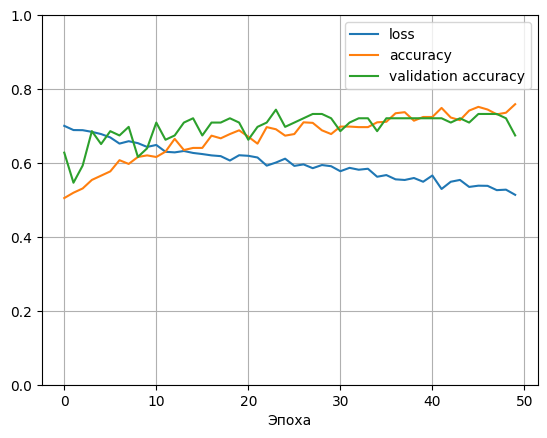

In [32]:
plot_epochs(bin_mlp_hist)

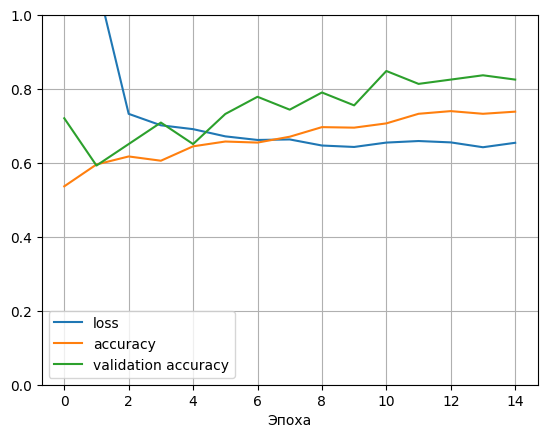

In [33]:
plot_epochs(bin_cnn_hist)

## 5. Сравнение качества бинарной классификации

In [34]:
from sklearn.metrics.cluster import fowlkes_mallows_score

In [35]:
bin_mlp_pred = bin_mlp.predict(b_test_images)
cls_bin_mlp_pred = np.array([1 if x > 0.5 else 0 for x in bin_mlp_pred])
bin_cnn_pred = bin_cnn.predict(b_test_images)
cls_bin_cnn_pred = np.array([1 if x > 0.5 else 0 for x in bin_cnn_pred])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 567ms/step


In [36]:
print("Score for MLP:", fowlkes_mallows_score(b_test_labels, cls_bin_mlp_pred))
print("Score for CNN:", fowlkes_mallows_score(b_test_labels, cls_bin_cnn_pred))

Score for MLP: 0.6077736349703134
Score for CNN: 0.7052311368935343


## 6. ROC-кривые

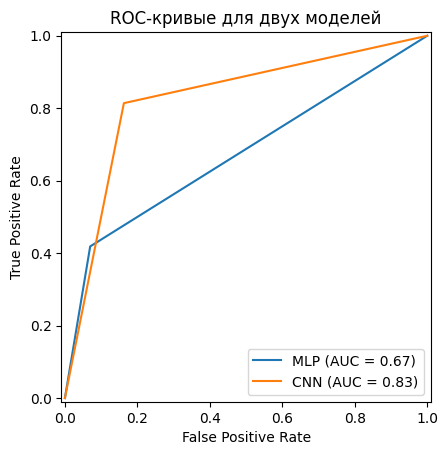

In [37]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(
    b_test_labels,
    cls_bin_mlp_pred,
    name="MLP",
    ax=ax
)

RocCurveDisplay.from_predictions(
    b_test_labels,
    cls_bin_cnn_pred,
    name="CNN",
    ax=ax
)

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC-кривые для двух моделей",
)

## 7. Многоклассовая классификация

### 7.1. Подготовка классов

In [13]:
np.unique(np.asarray(df_train["label"]))

array([0, 1, 2])

Нам нужны все элементы датасета, так как у нас всего существует три класса.

In [14]:
def to_one_hot(dataframe, dimension=3):
    results = np.zeros((len(dataframe), dimension))
    for i, label in enumerate(dataframe.to_numpy()):
        label = label[0]
        results[i, label] = 1.
    return results

In [15]:
train_labels = to_one_hot(pd.DataFrame(df_train, columns=["label"]))
test_labels = to_one_hot(pd.DataFrame(df_test, columns=["label"]))
train_labels.shape, test_labels.shape

((1034, 3), (128, 3))

In [16]:
train_images = np.zeros(shape=(df_train.shape[0],*input_shape), dtype=np.float32)
test_images  = np.zeros(shape=(df_test.shape[0],*input_shape), dtype=np.float32)
train_images.shape, test_images.shape

((1034, 500, 500, 3), (128, 500, 500, 3))

In [17]:
for idx in range(train_labels.shape[0]):
    train_images[idx,:,:,:] = \
        np.array(Image.fromarray(df_train.iloc[idx]['image']))

for idx in range(test_labels.shape[0]):
    test_images[idx,:,:,:] = \
        np.array(Image.fromarray(df_test.iloc[idx]['image']))

train_images.shape, test_images.shape

((1034, 500, 500, 3), (128, 500, 500, 3))

In [18]:
train_images /= 255
test_images  /= 255

### 7.2. MLP

In [22]:
tf.random.set_seed(rng_state)
dropout_rate = 0.3

mlp = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="leaky_relu"),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(90, activation="leaky_relu"),
    tf.keras.layers.Dense(80, activation="leaky_relu"),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(70, activation="leaky_relu"),
    tf.keras.layers.Dense(60, activation="leaky_relu"),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(50, activation="leaky_relu"),
    tf.keras.layers.Dense(3, activation="softmax"),
])

mlp.summary()

mlp.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adadelta(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

mlp_hist = mlp.fit(
    train_images,
    train_labels,
    epochs=20,
    validation_data=(test_images, test_labels)
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 750000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │    75,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 90)             │         9,090 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 70)             │         5,670 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 60)             │         4,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,029,603 (286.22 MB)

 Trainable params: 75,029,603 (286.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2024-05-17 06:45:02.808460: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3102000000 exceeds 10% of free system memory.


33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 791ms/step - accuracy: 0.6511 - loss: 0.6731 - val_accuracy: 0.6667 - val_loss: 0.6418
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 823ms/step - accuracy: 0.6507 - loss: 0.6490 - val_accuracy: 0.6667 - val_loss: 0.6419
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 840ms/step - accuracy: 0.6554 - loss: 0.6505 - val_accuracy: 0.6667 - val_loss: 0.6248
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 803ms/step - accuracy: 0.6607 - loss: 0.6431 - val_accuracy: 0.6667 - val_loss: 0.6253
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 791ms/step - accuracy: 0.6688 - loss: 0.6398 - val_accuracy: 0.6667 - val_loss: 0.6265
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 787ms/step - accuracy: 0.6646 - loss: 0.6238 - val_accuracy: 0.6953 - val_loss: 0.6058
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 785ms/step - accuracy: 0.6835 - loss: 0.6142 - val_accuracy: 0.6458 - val_loss: 0.6157
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 786ms/step - accuracy: 0.6743 - loss: 0.6215 - val_accuracy: 0.669

### 7.3. CNN

In [19]:
tf.random.set_seed(rng_state)
dropout_rate = 0.3
l2 = 0.1

cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding="same"),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding="same"),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=dropout_rate),
    tf.keras.layers.Dense(64, activation="swish", kernel_regularizer=tf.keras.regularizers.L2(l2=l2)),
    tf.keras.layers.Dense(3, activation="softmax")
])

cnn.summary()

cnn.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.AdamW(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

cnn_hist = cnn.fit(
    train_images,
    train_labels,
    epochs=5,
    validation_data=(test_images, test_labels)
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 498, 498, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 249, 249, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 247, 247, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 124, 124, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 122, 122, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 59536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 59536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,810,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,815,651 (14.56 MB)

 Trainable params: 3,815,651 (14.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


2024-05-17 06:38:42.182073: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3102000000 exceeds 10% of free system memory.


33/33 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6014 - loss: 7.5437 - val_accuracy: 0.5521 - val_loss: 1.2023
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6268 - loss: 0.9690 - val_accuracy: 0.5938 - val_loss: 0.7275
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6425 - loss: 0.6996 - val_accuracy: 0.7188 - val_loss: 0.6647
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6971 - loss: 0.6604 - val_accuracy: 0.5911 - val_loss: 0.7358
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6857 - loss: 0.6787 - val_accuracy: 0.6823 - val_loss: 0.6251


## 8. Оценка качества

In [20]:
from sklearn.metrics import precision_score

In [25]:
mlp_pred = mlp.predict(test_images)
cls_mlp_pred = np.array([[1 if prob > 0.5 else 0 for prob in x] for x in mlp_pred])
cnn_pred = cnn.predict(test_images)
cls_cnn_pred = np.array([[1 if prob > 0.5 else 0 for prob in x] for x in cnn_pred])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


In [27]:
print("Score for MLP:", precision_score(np.ravel(test_labels), np.ravel(cls_mlp_pred)))
print("Score for CNN:", precision_score(np.ravel(test_labels), np.ravel(cls_cnn_pred)))

Score for MLP: 0.660377358490566
Score for CNN: 0.5294117647058824


## 9. Кривые обучения

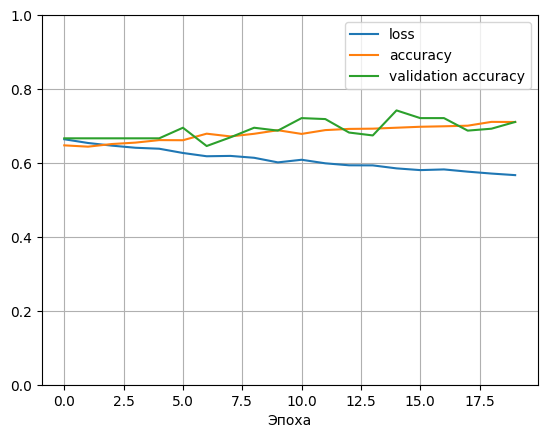

In [31]:
plot_epochs(mlp_hist)

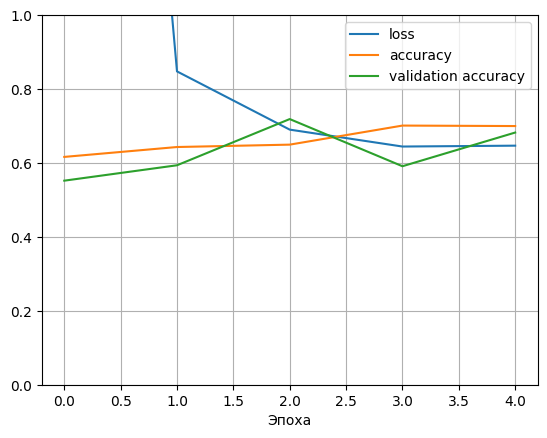

In [32]:
plot_epochs(cnn_hist)

# Замечание

Мне пришлось резко сократить количество эпох, нейронов и/или других параметров сетей в некоторых сетях, так как моему компьютеру не хватало вычислительных мощностей.